In [1]:
from functools import partial
from typing import Any

import click
import optuna
from gnn_tracking.models.track_condensation_networks import PerfectECGraphTCN
from gnn_tracking.training.dynamiclossweights import NormalizeAt
from gnn_tracking.utils.dictionaries import subdict_with_prefix_stripped
from torch import nn

from gnn_tracking_hpo.config import auto_suggest_if_not_fixed, get_metadata
from gnn_tracking_hpo.trainable import TCNTrainable, suggest_default_values
from gnn_tracking_hpo.tune import common_options, main

In [2]:
class DynamicTCNTrainable(TCNTrainable):
    def get_loss_functions(self) -> dict[str, Any]:
        return {
            "potential": self.get_potential_loss_function(),
            "background": self.get_background_loss_function(),
        }

    def get_cluster_functions(self) -> dict[str, Any]:
        return {}

    def get_loss_weights(self):
        relative_weights = [
            {},
            subdict_with_prefix_stripped(self.tc, "rlw_"),
        ]
        return NormalizeAt(
            at=[0, 1],
            relative_weights=relative_weights,
        )

    def get_model(self) -> nn.Module:
        return PerfectECGraphTCN(
            node_indim=6, edge_indim=4, **subdict_with_prefix_stripped(self.tc, "m_"),
        )
        pass


In [39]:
def get_config(
) -> dict[str, Any]:
    config = get_metadata()

    def d(key, *args, **kwargs):
        auto_suggest_if_not_fixed(key, config, None, *args, **kwargs)

    d("sector", 9)
    d("n_graphs_train", 20)
    d("n_graphs_val", 10)
    d("n_graphs_test", 1)
    d("training_pt_thld", 0.3)
    d("training_without_noise", False)
    d("batch_size", 1)
    d("m_h_outdim", 2)
    d("m_ec_tnr", 1)
    d("m_ec_tpr", 0.6)


    suggest_default_values(config, None, perfect_ec=True)
    return config

In [40]:
config = get_config()

In [47]:
config["m_h_dim"]

5

In [41]:
def collect_latent_spaces(trainer, model_output):
    if not hasattr(trainer, "latent_spaces"):
        trainer.latent_spaces = []
    trainer.latent_spaces.append(model_output["x"])

In [42]:
trainable = DynamicTCNTrainable(config)
# trainable.trainer.add_hook(collect_latent_spaces, "batch")

DEBUG: Got config
{'attr_pt_thld': 0.9,
 'batch_size': 1,
 'gnn_tracking_experiments_hash': 'efed91462fea5b9ef534ef30dc6d21ee7188bf18',
 'gnn_tracking_hash': 'c0c61a844424802edf8c84e8b4a518e8d4d663c8',
 'lr': 0.0005,
 'm_L_hc': 3,
 'm_alpha_hc': 0.5,
 'm_e_dim': 4,
 'm_ec_tnr': 1,
 'm_ec_tpr': 0.6,
 'm_h_dim': 5,
 'm_h_outdim': 2,
 'm_hidden_dim': 40,
 'n_graphs_test': 1,
 'n_graphs_train': 20,
 'n_graphs_val': 10,
 'optimizer': 'adam',
 'q_min': 0.01,
 'sb': 0.1,
 'scheduler': None,
 'sector': 9,
 'test': False,
 'training_pt_thld': 0.3,
 'training_without_noise': False}
INFO: Loading data to cpu memory
INFO: Loading 31 graphs (out of 371 available).
DEBUG: Parameters for data loaders: {'batch_size': 1, 'num_workers': 12}
/scratch/gpfs/kl5675/miniconda3/envs/gnn/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this

In [43]:
for i in range(1):
    trainable.step()

INFO: Epoch  1 (    0/20): background_weighted=   0.49984, potential_attractive_weighted=   0.00001, potential_repulsive_weighted= 456.79977
INFO: Epoch  1 (   10/20): background_weighted=   0.52277, potential_attractive_weighted=   0.00003, potential_repulsive_weighted= 357.77109
INFO: Training for epoch 1 took 4.76 seconds
/scratch/gpfs/kl5675/miniconda3/envs/gnn/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/scratch/gpfs/kl5675/miniconda3/envs/gnn/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes 

In [44]:
import torch
trainer = trainable.trainer
sel = 5

with torch.no_grad():
    loader = trainer.val_loader
    for idx, data in enumerate(loader):
        if idx < sel:
            continue
        model_output = trainer.evaluate_model(data, mask_pids_reco=False)
        if idx == sel:
            break

x = model_output["x"]

/scratch/gpfs/kl5675/miniconda3/envs/gnn/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


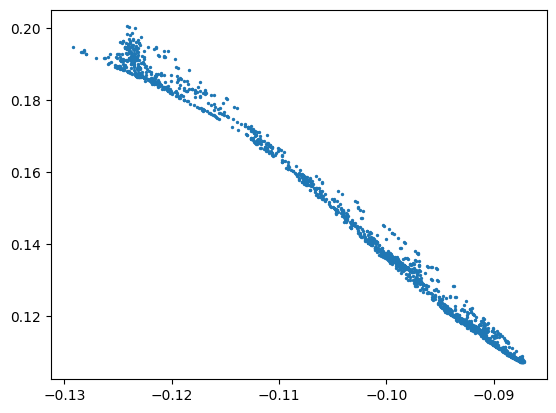

In [45]:
import matplotlib.pyplot as plt
plt.scatter(x[:, 0], x[:, 1], s=2)

(array([1023.,  705.,  244.,  153.,   64.,   30.,   12.,   17.,    2.,
           6.]),
 array([0.        , 0.354682  , 0.709364  , 1.06404603, 1.41872799,
        1.77340996, 2.12809205, 2.48277402, 2.83745599, 3.19213796,
        3.54681993]),
 <BarContainer object of 10 artists>)

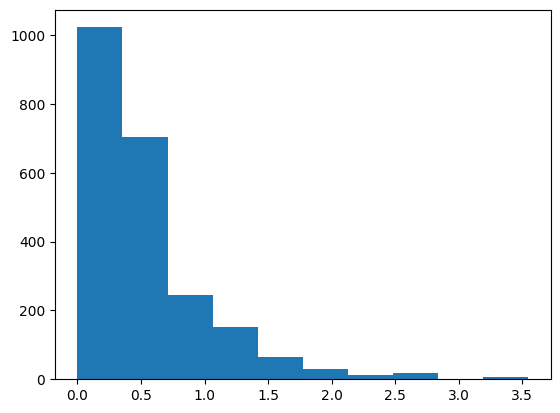

In [27]:
from matplotlib import pyplot as plt

plt.hist(data.pt)